In [2]:
import json
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler

from tpot import TPOTClassifier 
import models.DecisionTreeClassifier as dtc
import models.RandomForestClassifier as rfc
import models.SupportVectorMachine as spm
import models.GradientBoostingClassifier as gbc
import models.DummyClassifiers as dummies
import models.LogisticRegression as lr
import feature_reduction.PCA as pca_wrapper
import evaluation.Evaluation as eval

# reads dataset.json-file and parses it to an obj
def readFile(filepath):
    file = open(filepath, "r")
    content = file.read()
    json_content = json.loads(content)
    print(json_content.keys())
    #print(json_content["data"])
    return dotdict(json_content)

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# Reading Dataset from file

In [8]:
import os
script_dir = os.path.abspath("")
rel_path = "../datasets/Dataset_predQuanti_postAnno_5_5.json"
dataset_file_path = os.path.join(script_dir, rel_path)
dataset = readFile(dataset_file_path)
df = pd.DataFrame(data= np.c_[dataset.target, dataset.data], columns=dataset.targetNames + dataset.featureNames)
df.head()

dict_keys(['data', 'target', 'keys', 'featureNames', 'targetNames', 'description', 'traceAP'])


,Fixes,minValCognitiveComplexity,minValDuplicatedLinesDensity,minValSecurityRating,minValBlockerViolations,minValDuplicatedBlocks,minValVulnerabilities,minValSqaleIndex,minValInfoViolations,minValGeneratedNcloc,...,meanRelDiffTestSuccessDensity,meanRelDiffFalsePositiveIssues,meanRelDiffTestFailures,meanRelDiffSqaleRating,meanRelDiffReliabilityRating,meanRelDiffFiles,meanRelDiffWontFixIssues,meanRelDiffSkippedTests,meanRelDiffEffortToReachMaintainabilityRatingA,meanRelDiffTestErrors
0,0.0,290.0,0.0,1.0,0.0,0.0,0.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,456.0,0.0,1.0,0.0,0.0,0.0,55.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
2,0.0,9858.0,0.0,1.0,3.0,0.0,0.0,11188.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Data preparation
Preparing data before using it to train different models
## Standardization
Standardizing data. Some models are sensitive against outlier values. <br>
They perform better with standardized data. <br>
Model that might benefit from standardization: Polynomial Regression <br>
## Min-Max-Scaler: Normalisation
The min-max-scaler transforms all data to be within the min- and max-values. <br>
## Feature Reduction - "Curse of dimensionality"
Some models have poor training performance. A lot of features might lead to very high training times.<br>
Usually it is best to keep as many features as suitable.<br>
Model that has poor training performance: Support Vector Machines<br>
### PCA - Principal Component Analysis
PCA is a feature reduction algorithm which tries to reduce all features into less features while keeping as much<br>
variance of the data as possible. The idea is that most information is kept in most of the variance ratio.<br>
Concept: If you have 2 Dimensions (x- + y- axis) you can plot all points into that grid and try to plot one new axis<br>
and measure the distances of the points to the axis. Therefore you stay with one feature left.<br>
Now you do not know what the feature´s semantic is though.

In [4]:
# Prepare data
x = np.array(dataset.data[:])
y = (np.array(dataset.target)).ravel() # make 1d-Array

y_binary = np.copy(y)
for idx, val in np.ndenumerate(y_binary):
    if(val > 1):
        y_binary[idx] = 1


# Standardized
standard_scaler = StandardScaler()
standard_scaler.fit(dataset.data)
x_standardized = standard_scaler.transform(x)

# Min-Max-Scaler: normalisation
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(dataset.data)
x_normalized = min_max_scaler.transform(x)

# PCA 
x_pca = pca_wrapper.pca(x_standardized, 0.98)

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(x, y_binary, test_size=0.3, random_state=42)
x_train_standardized, x_test_standardized, y_train_standardized, y_test_standardized = train_test_split(x_standardized, y, test_size=0.30, random_state=42)
x_train_normalized, x_test_normalized, y_train_normalized, y_test_normalized = train_test_split(x_normalized, y, test_size=0.3, random_state=42)
x_train_binary_standardized, x_test_binary_standardized, y_train_binary_standardized, y_test_binary_standardized = train_test_split(x_standardized, y_binary, test_size=0.30, random_state=42)
x_train_binary_normalized, x_test_binary_normalized, y_train_binary_normalized, y_test_binary_normalized = train_test_split(x_normalized, y_binary, test_size=0.3, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.30, random_state=42)
x_train_binary_pca, x_test_binary_pca, y_train_binary_pca, y_test_binary_pca = train_test_split(x_pca, y_binary, test_size=0.30, random_state=42)

# Generate DataFrame from test and train set as it is needed for h2o 
df_train = pd.DataFrame(data=np.c_[y_train, x_train], columns=dataset.targetNames + dataset.featureNames)
df_test = pd.DataFrame(data=np.c_[y_test, x_test], columns=dataset.targetNames + dataset.featureNames)
df_pca_train = pd.DataFrame(data=np.c_[y_train_pca, x_train_pca], columns=dataset.targetNames + [idx for idx, val in enumerate(x_test_pca[0])])
df_pca_test = pd.DataFrame(data=np.c_[y_test_pca, x_test_pca], columns=dataset.targetNames + [idx for idx, val in enumerate(x_test_pca[0])])
df_train_binary = pd.DataFrame(data=np.c_[y_train_binary, x_train_binary], columns=dataset.targetNames + dataset.featureNames)
df_test_binary = pd.DataFrame(data=np.c_[y_test_binary, x_test_binary], columns=dataset.targetNames + dataset.featureNames)

Sum of Explained Variance Ratio: 0 with: 0 components.
Sum of Explained Variance Ratio: 0.2339 with: 1 components.
Sum of Explained Variance Ratio: 0.3448 with: 2 components.
Sum of Explained Variance Ratio: 0.4175 with: 3 components.
Sum of Explained Variance Ratio: 0.4749 with: 4 components.
Sum of Explained Variance Ratio: 0.5244 with: 5 components.
Sum of Explained Variance Ratio: 0.5728 with: 6 components.
Sum of Explained Variance Ratio: 0.6099 with: 7 components.
Sum of Explained Variance Ratio: 0.6439 with: 8 components.
Sum of Explained Variance Ratio: 0.6725 with: 9 components.
Sum of Explained Variance Ratio: 0.6968 with: 10 components.
Sum of Explained Variance Ratio: 0.7193 with: 11 components.
Sum of Explained Variance Ratio: 0.74 with: 12 components.
Sum of Explained Variance Ratio: 0.7595 with: 13 components.
Sum of Explained Variance Ratio: 0.7773 with: 14 components.
Sum of Explained Variance Ratio: 0.7925 with: 15 components.
Sum of Explained Variance Ratio: 0.8073 w

# Simple data analysis
Next two cells! <br>
Sometimes it might be usefull to explore data before modelling.<br>
Some features might obviously have high predictive power others don´t.<br>
Simple analysis: Plotting 1 feature vs corresponding classes. <br>

In [ ]:
# Run next cell, too!
df.describe()

In [53]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print("Class occurences:\n", frequencies, "\n")

minValLines = x[:,9]
maxValLines = x[:,37]
meanDiffLines = x[:,152]
meanRelDiffLines = x[:,219]

for idx, val in enumerate(dataset.featureNames):
    if (val == "maxValLines"):
        print("maxValLines: ", idx)
    if(val == "minValLines"):
        print("minValLines ", idx)
    if(val == "meanRelDiffLines"):
        print("meanRelDiffLines ", idx)
    if(val == "meanDiffLines"):
        print("meanDiffLines ", idx)


fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=2.0)
ylabel = "#fixes"
axs[0, 0].scatter(minValLines, y)
axs[0, 0].set(xlabel="minValLines")
axs[0, 0].set(ylabel=ylabel)

axs[0, 1].scatter(maxValLines, y)
axs[0, 1].set(xlabel="maxValLines")
axs[0, 1].set(ylabel=ylabel)

axs[1, 0].scatter(meanDiffLines, y)
axs[1, 0].set(xlabel="meanDiffLines")
axs[1, 0].set(ylabel=ylabel)

axs[1, 1].scatter(meanRelDiffLines, y)
axs[1, 1].set(xlabel="meanRelDiffLines")
axs[1, 1].set(ylabel=ylabel)

image_format = "svg"
image_name = "features-fixes"
fig.savefig(image_name + "." + image_format, format=image_format, dpi=1000)
fig.savefig(image_name + ".png", dpi=500)

Class occurences:
 [[   0 8671]
 [   1 2076]
 [   2  305]
 [   3   27]
 [   4    1]] 



TypeError: list indices must be integers or slices, not tuple

# Decision Tree Classifier
Simple model. Most likely not the best performing model.
Tries to split classes based on a decision tree of the features.
Why using Decision Trees if they tend to perform bad?
You can plot Decision Trees and make them human readable. 
If your decision tree performs great, plot it and understand what decisions lead to which classification.

Grid search: finding best hyperparameter for DecisionTreeClassifier...
Parameters of best model: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}
Score of best model: 0.7846829065513801
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2588
           1       0.57      0.01      0.02       642
           2       0.00      0.00      0.00        85
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         1

    accuracy                           0.78      3324
   macro avg       0.27      0.20      0.18      3324
weighted avg       0.72      0.78      0.69      3324


x-axis: actual values, y-axis: predicted values
[[2584    4    0    0    0]
 [ 634    8    0    0    0]
 [  83    2    0    0    0]
 [   8    0    0    0    0]
 [   1    0    0    0    0]]
Mean absolute error: 0.2509025270758123
Top 5 most important features:
	 maxValViolations   0.7350074680612417
	 maxValSecurit

C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


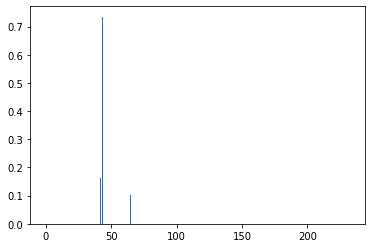

In [4]:
# DecisionTreeClassifier
dtc_model = dtc.model(x_train, y_train)
eval.evaluate(dtc_model, x_test, y_test, dataset.featureNames)

# RandomForestClassifier
Ensemble: Bagging of DecisionTreeClassifier.
Train many trees with different features and calculate mean value in case of regression
or use majority voter in case of classification.
RandomForests tend to overfitting especially when using a lot of trees. 
Therefore better performance achieved with train-data might lead to worse performance with test-data.

Grid search: finding best hyperparameter for RandomForestClassifier...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.0s finished


Parameters of best model: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 250}
Score of best model: 0.8229762221483206


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2588
           1       0.64      0.38      0.48       642
           2       0.31      0.12      0.17        85
           3       0.40      0.25      0.31         8
           4       0.00      0.00      0.00         1

    accuracy                           0.82      3324
   macro avg       0.44      0.34      0.37      3324
weighted avg       0.80      0.82      0.80      3324


x-axis: actual values, y-axis: predicted values
[[2486  102    0    0    0]
 [ 379  244   19    0    0]
 [  36   36   10    3    0]
 [   3    0    3    2    0]
 [   1    0    0    0    0]]
Mean absolute error: 0.18862815884476533
Top 5 most important features:
	 meanValLines   0.04017690357333269
	 maxValLines   0.03597980350238366
	 minValLines   0.03421423944946851
	 maxRelDiffLines   0.03263083302145146
	 meanValCognitiveComplexity   0.032133874241074924

Most important features: x-Axis: feature, y-Axi

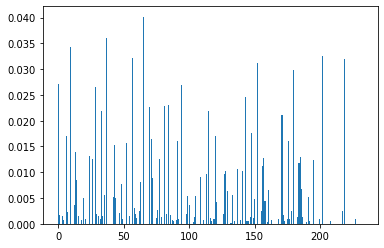

In [6]:
# RandomForestClassifier
rfc_model = rfc.model(x_train, y_train) # if weird OS bug occures: n_jobs = -1 might not be working
eval.evaluate(rfc_model, x_test, y_test, dataset.featureNames)

# Saving plot as svg
If you like to save a plot as a svg-file, you can use the following template.<br>
Important: savefig-call needs to be before show-call!

In [ ]:
importances = rfc_model.feature_importances_
plt.bar([x for x in range(len(importances))], importances)
plt.savefig("random-forest-importances.svg", format="svg")
plt.show()

## Binary RandomForestClassifier PCA

Grid search: finding best hyperparameter for RandomForestClassifier...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    9.3s finished


Parameters of best model: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 160}
Score of best model: 0.807762221483206
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2588
           1       0.65      0.35      0.45       736

    accuracy                           0.81      3324
   macro avg       0.74      0.65      0.67      3324
weighted avg       0.79      0.81      0.79      3324


x-axis: actual values, y-axis: predicted values
[[2448  140]
 [ 481  255]]
Mean absolute error: 0.18682310469314078
Top 5 most important features:
	 minValCognitiveComplexity   0.03652711371380811
	 maxValSecurityHotspots   0.02490723397712521
	 maxValFalsePositiveIssues   0.0248950285092029
	 minValSqaleIndex   0.02420964217400777
	 minValDuplicatedLinesDensity   0.023478522212169634

Most important features: x-Axis: feature, y-Axis: importance


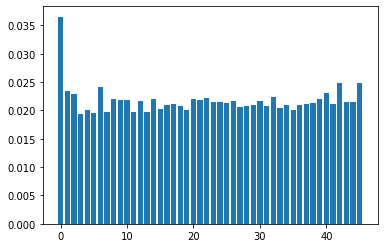

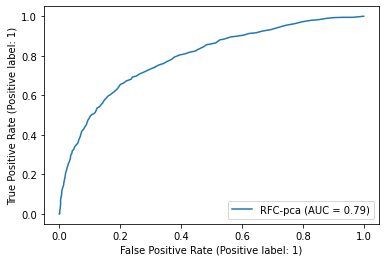

In [22]:
brfc_pca_model = rfc.model(x_train_binary_pca, y_train_binary_pca) # if weird OS bug occures: n_jobs = -1 might not be working
eval.evaluate(brfc_pca_model, x_test_binary_pca, y_test_binary_pca, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(brfc_pca_model, x_test_binary_pca, y_test_binary_pca, name="RFC-pca")
plt.show()

## Binary RandomForestClassifier

Grid search: finding best hyperparameter for RandomForestClassifier...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    2.5s finished


Parameters of best model: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 160}
Score of best model: 0.8438611572996342
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2588
           1       0.73      0.46      0.56       736

    accuracy                           0.84      3324
   macro avg       0.80      0.70      0.73      3324
weighted avg       0.83      0.84      0.83      3324


x-axis: actual values, y-axis: predicted values
[[2465  123]
 [ 401  335]]
Mean absolute error: 0.15764139590854392
Top 5 most important features:
	 meanValLines   0.040046569734934014
	 maxValLines   0.03601153858625334
	 minValLines   0.03425789355603506
	 meanValCognitiveComplexity   0.03375914461357922
	 meanRelDiffLines   0.03342062602853522

Most important features: x-Axis: feature, y-Axis: importance


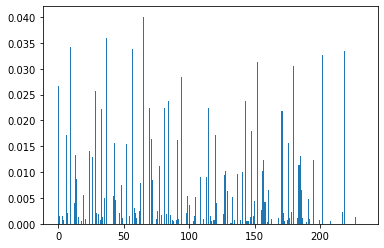

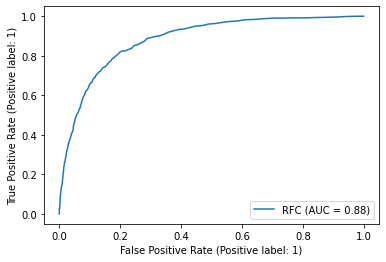

In [23]:
brfc_model = rfc.model(x_train_binary, y_train_binary) # if weird OS bug occures: n_jobs = -1 might not be working
eval.evaluate(brfc_model, x_test_binary, y_test_binary, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(brfc_model, x_test_binary, y_test_binary, name="RFC")
plt.show()

# GradientBoostingClassifier

Grid search: finding best hyperparameter for DecisionTreeClassifier...


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\ensemble\_gb.py", line 310, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  Fil

      Iter       Train Loss   Remaining Time 
         1           0.5322            1.72m
         2           0.4801            1.73m
         3           0.4464            1.73m
         4           0.4124            1.73m
         5           0.3875            1.72m
         6           0.3656            1.71m
         7           0.3476            1.70m
         8           0.3342            1.70m
         9           0.3180            1.69m
        10           0.3047            1.68m
        20           0.2171            1.59m
        30           0.1739            1.51m
        40           0.1438            1.40m
        50           0.1211            1.29m
        60           0.1037            1.18m
        70           0.0871            1.06m
        80           0.0729           56.71s
        90           0.0616           49.68s
       100           0.0510           42.62s
Parameters of best model: {'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 10, 'n_est

C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2588
           1       0.66      0.40      0.50       642
           2       0.31      0.13      0.18        85
           3       0.20      0.25      0.22         8
           4       0.00      0.00      0.00         1

    accuracy                           0.83      3324
   macro avg       0.41      0.35      0.36      3324
weighted avg       0.81      0.83      0.81      3324


x-axis: actual values, y-axis: predicted values
[[2483  103    1    1    0]
 [ 361  259   20    2    0]
 [  37   32   11    5    0]
 [   3    0    3    2    0]
 [   1    0    0    0    0]]
Mean absolute error: 0.1865222623345367
Top 5 most important features:
	 maxRelDiffLines   0.0562175658363661
	 meanValLines   0.05524517223251697
	 minRelDiffLines   0.0469531550086536
	 maxValLines   0.04568020742550077
	 minValLines   0.039279992536624495

Most important features: x-Axis: feature, y-Axis: importance


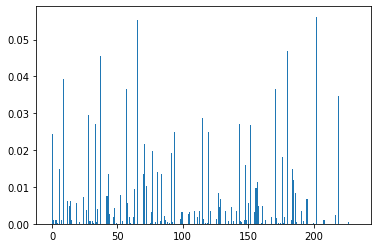

In [8]:
gbc_model = gbc.model(x_train, y_train)
eval.evaluate(gbc_model, x_test, y_test, dataset.featureNames)

# Binary GradientBoostingClassifier

Grid search: finding best hyperparameter for DecisionTreeClassifier...
      Iter       Train Loss   Remaining Time 
         1           0.9784           31.38s
         2           0.9162           30.23s
         3           0.8751           28.77s
         4           0.8354           28.36s
         5           0.7953           27.81s
         6           0.7622           27.75s
         7           0.7310           27.98s
         8           0.7029           29.03s
         9           0.6773           29.23s
        10           0.6554           29.51s
        20           0.5035           29.39s
        30           0.4081           27.61s
        40           0.3538           25.40s
        50           0.3069           23.30s
        60           0.2660           21.25s
        70           0.2306           19.35s
        80           0.2129           17.16s
        90           0.1908           15.03s
       100           0.1722           12.86s
Parameters of best model: {'

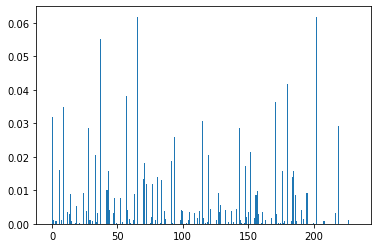

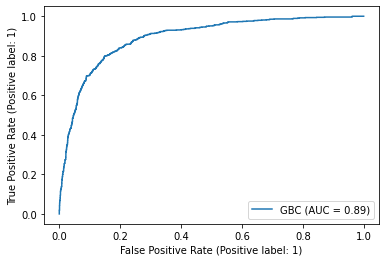

In [24]:
bgbc_model = gbc.model(x_train_binary, y_train_binary)
eval.evaluate(bgbc_model, x_test_binary, y_test_binary, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(bgbc_model, x_test_binary, y_test_binary, name="GBC")
plt.show()

# Support Vector Machines
Support Vector Machines can make good models but need more computing time to fit data.<br>
Therefore it might be necessary to use feature-reduction before fitting the model.

In [10]:
svm_model = spm.model(x_train_pca, y_train_pca)
eval.evaluate(svm_model, x_test_pca, y_test_pca, dataset.featureNames)

Grid search: finding best hyperparameter for SupportVectorMachine...


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.f

[LibSVM]

TypeError: 'numpy.int32' object is not iterable

## Binary Support Vector Machine

In [ ]:
bsvm_model = spm.model(x_train_pca, y_train_pca)
eval.evaluate(bsvm_model, x_test_pca, y_test_pca, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(bsvm_model, x_test_binary, y_test_binary, name="SVM")
plt.show()

# Logstic Regression

## Logistic Regression with min-max-scaled data

In [11]:
lrc_standardized_model = lr.model(x_train_standardized, y_train_standardized)
eval.evaluate(lrc_standardized_model, x_test_standardized, y_test_standardized, dataset.featureNames)

Grid search: finding best hyperparameter for DecisionTreeClassifier...


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
280 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _

Parameters of best model: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2'}
Score of best model: 0.7842961423345527
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2588
           1       1.00      0.00      0.00       642
           2       0.00      0.00      0.00        85
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         1

    accuracy                           0.78      3324
   macro avg       0.36      0.20      0.18      3324
weighted avg       0.80      0.78      0.68      3324


x-axis: actual values, y-axis: predicted values
[[2588    0    0    0    0]
 [ 641    1    0    0    0]
 [  85    0    0    0    0]
 [   8    0    0    0    0]
 [   1    0    0    0    0]]
Mean absolute error: 0.25240673886883275


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Binary Logistic Regression with standardized data

Grid search: finding best hyperparameter for DecisionTreeClassifier...


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
280 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _

Parameters of best model: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2'}
Score of best model: 0.7849403059527769
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2588
           1       1.00      0.01      0.01       736

    accuracy                           0.78      3324
   macro avg       0.89      0.50      0.44      3324
weighted avg       0.83      0.78      0.68      3324


x-axis: actual values, y-axis: predicted values
[[2588    0]
 [ 732    4]]
Mean absolute error: 0.22021660649819494


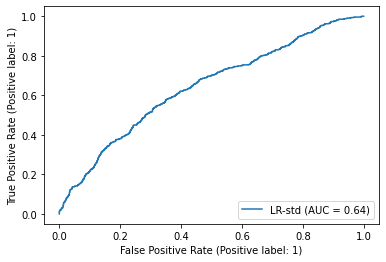

In [21]:
lrc_standardized_model = lr.model(x_train_binary_standardized, y_train_binary_standardized)
eval.evaluate(lrc_standardized_model, x_test_binary_standardized, y_test_binary_standardized, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(lrc_standardized_model, x_test_binary_standardized, y_test_binary_standardized, name="LR-std")
plt.show()

## Binary Logistic Regression with min-max-scaled data

Grid search: finding best hyperparameter for DecisionTreeClassifier...


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
280 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _

Parameters of best model: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}
Score of best model: 0.7845533754572663
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2588
           1       0.79      0.01      0.03       736

    accuracy                           0.78      3324
   macro avg       0.78      0.51      0.45      3324
weighted avg       0.78      0.78      0.69      3324


x-axis: actual values, y-axis: predicted values
[[2585    3]
 [ 725   11]]
Mean absolute error: 0.2190132370637786


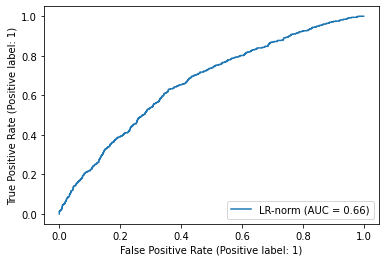

In [25]:
lrc_normalized_model = lr.model(x_train_binary_normalized, y_train_binary_normalized)
eval.evaluate(lrc_normalized_model, x_test_binary_normalized, y_test_binary_normalized, dataset.featureNames)

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(lrc_normalized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR-norm")
plt.show()

# Automated machine learning
There are different approaches to automize machine learning. <br>
One of which is **T**ree-based **P**ipeline **O**ptimization **T**ool which optimizes machine learning pipelines using genetic programming. <br>
There are other automated machine learning tools like Azure AutoML and Google Cloud AutoML which need further investigation.<br>
Investigate https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html, too.

## TPOT

In [ ]:
# TPOT http://epistasislab.github.io/tpot/using/
tpot = TPOTClassifier(generations=100, verbosity=2, memory="./tpot-memory")
tpot.fit(x_train, y_train)
tpot.export("./models/tpot.py")

This is one exported pipeline generated by TPOT.<br>
You can insert the code from ./tpot_test.py into the next cell after training.<br>
The only adaptation you need to do: <br>


tpot_data = dataset<br>
training_features, testing_features, training_target, testing_target = x_train, x_test, y_train, y_test


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

tpot_data = dataset
training_features, testing_features, training_target, testing_target = x_train, x_test, y_train, y_test
# Average CV score on the training set was: 0.8133050177138793
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.7000000000000001, min_samples_leaf=4, min_samples_split=14, n_estimators=100, subsample=0.9500000000000001)),
    XGBClassifier(learning_rate=0.01, max_depth=1, min_child_weight=19, n_estimators=100, n_jobs=1, subsample=0.15000000000000002, verbosity=0)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

eval.evaluate(exported_pipeline, x_test, y_test, dataset.featureNames)


## Binary TPOT

In [10]:
# TPOT http://epistasislab.github.io/tpot/using/
tpot_binary = TPOTClassifier(generations=2, verbosity=2, memory="./tpot-memory")
tpot_binary.fit(x_train_binary, y_train_binary)
tpot_binary.export("./models/trained_models/tpot_binary.py")


Generation 1 - Current best internal CV score: 0.8287774099849117

Generation 2 - Current best internal CV score: 0.8309685470630853

Best pipeline: DecisionTreeClassifier(RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=2, min_samples_split=16, n_estimators=100), criterion=entropy, max_depth=3, min_samples_leaf=15, min_samples_split=5)


NameError: name 'tpot' is not defined

## H2O

In [9]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)
# train, test = h2o_df.split_frame(ratios=[.75])

target_name = "Fixes"
x = h2o_train.columns
x.remove(target_name)

# needed for classification. If not set like that it will go for regression
h2o_train[target_name] = h2o_train[target_name].asfactor()
h2o_test[target_name] = h2o_test[target_name].asfactor()

# If you run with project_name and different seeds new Models will be added to existing leaderboard
# Still not ideal for rerunning as same models might be exploited again
aml = H2OAutoML(max_runtime_secs=60*60*2, project_name="AutoML_h2o",seed=1)
aml.train(x=x, y=target_name, training_frame=h2o_train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# Save the model
h2o.save_model(model=aml.leader, path="./models/trained_model_dumps/h2o.model", force=True)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.43+55-CA (build 11.0.9.1+1-LTS, mixed mode)
  Starting server from C:\Users\Robert\anaconda3\envs\ml\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Robert\AppData\Local\Temp\tmp_ha9b2ig
  JVM stdout: C:\Users\Robert\AppData\Local\Temp\tmp_ha9b2ig\h2o_Robert_started_from_python.out
  JVM stderr: C:\Users\Robert\AppData\Local\Temp\tmp_ha9b2ig\h2o_Robert_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_Robert_x0vqav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.980 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:28:13.199: AutoML: XGBoost is not available; skipping it.
14:28:13.216: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
14:28:13.216: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


'C:\\bugFinder\\packages\\bugFinder-machineLearning\\src\\models\\trained_model_dumps\\h2o.model\\GBM_grid_1_AutoML_1_20211119_142813_model_41'

In [14]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
h2o_model = h2o.load_model("./models/trained_model_dumps/h2o.model/GBM_grid_1_AutoML_1_20211119_142813_model_41")
predictions = h2o_model.predict(h2o_test)
numpy_predictions = predictions.as_data_frame().to_numpy()
predictions_class = predictions["predict"].as_data_frame().to_numpy()

# h2o model predicts probabilities for each class in training set. Therefore 4 values are predicted
# for each feature samle
numpy_y_test = h2o_test[target_name].as_data_frame().to_numpy()
eval.regression_report(numpy_y_test, predictions_class)
eval.classification_report(numpy_y_test, predictions_class)
print(h2o_model.confusion_matrix(data=h2o_test))

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 54 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_Robert_x0vqav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.839 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2588
           1       0.64      0.43      0.51       642
           2       0.41      0.19      0.26        85
           3       0.43      0.38      0.40         8
           4       0.00      0.00      0.00         1

    accuracy                           0.83      3324
   macro avg       0.47      0.39      0.42      3324
weighted avg       0.81      0.83      0.81      3324


x-axis: actual values, y-axis: predicted values
[[2464  124    0    0    0]
 [ 346  277   19    0    0]
 [  32   33   16    4    0]
 [   1    0    4    3    0]
 [   1    0    0    0    0]]

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,Error,Rate
0,2464.0,124.0,0.0,0.0,0.0,0.047913,124 / 2.588
1,346.0,277.0,19.0,0.0,0.0,0.568536,365 / 642
2,32.0,33.0,16.0,4.0,0.0,0.811765,69 / 85
3,1.0,0.0,4.0,3.0,0.0,0.625000,5 / 8
4,1.0,0.0,0.0,0.0,0.0,1.000000,1 / 1
5,2844.0,434.0,39.0,7.0,0.0,0.169675,564 / 3.324


## Binary H2O

In [26]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
h2o_binary_train = h2o.H2OFrame(df_train_binary)
h2o_binary_test = h2o.H2OFrame(df_test_binary)
# train, test = h2o_df.split_frame(ratios=[.75])

target_name = "Fixes"
x = h2o_binary_train.columns
x.remove(target_name)

# needed for classification. If not set like that it will go for regression
h2o_binary_train[target_name] = h2o_binary_train[target_name].asfactor()
h2o_binary_test[target_name] = h2o_binary_test[target_name].asfactor()

# If you run with project_name and different seeds new Models will be added to existing leaderboard
# Still not ideal for rerunning as same models might be exploited again
aml_binary = H2OAutoML(max_runtime_secs=60*60*2, project_name="AutoML_h2o_binary",seed=1)
aml_binary.train(x=x, y=target_name, training_frame=h2o_binary_train)

# View the AutoML Leaderboard
lb_binary = aml_binary.leaderboard
lb_binary.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# Save the model
h2o.save_model(model=aml_binary.leader, path="./models/trained_model_dumps/h2o_binary.model", force=True)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,21 hours 26 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_Robert_x0vqav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.982 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
11:55:13.107: AutoML: XGBoost is not available; skipping it.
11:55:13.108: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
11:55:13.108: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


'C:\\bugFinder\\packages\\bugFinder-machineLearning\\src\\models\\trained_model_dumps\\h2o_binary.model\\StackedEnsemble_AllModels_5_AutoML_3_20211120_115513'

# Dummy Classifiers
You should compare your best classifier with some simple and "stupid" strategies <br>
to make sure your classifier is somewhat better than a very simple classification strategy. <br>
You might want to run the next cell twice, if you get warning and cannot see the whole output.

In [ ]:
# Run me twice if you get warnings
import warnings
warnings.filterwarnings("ignore")
print("WARNING: Warnings will be ignored. Some metrics might be ill defined " + 
    "as no prediction of certain classes might lead to cero division. " + 
    "Please interpret metrics with causion!")

dummy_models = dummies.models(x_train, y_train)
for idx, val in enumerate(dummy_models):
    print(val.strategy)
    eval.evaluate(val.model, x_test, y_test, dataset.featureNames)
    print("\n")

warnings.filterwarnings("always")

In [ ]:
# ROC comparison
import joblib
gbc = joblib.load("./models/trained_model_dumps/GradientBoostingClassifier.model")
lr = joblib.load("./models/trained_model_dumps/LogisticRegression.model")
rfc = joblib.load("./models/trained_model_dumps/RandomForestClassifier.model")

# H2O

# TPOT

# Compute ROC curve and AUC
rfc_disp = RocCurveDisplay.from_estimator(lrc_normalized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR-norm")
plt.show()

h2o auc:  0.8855734661649083
[0.01694915 0.         0.94791667 0.         0.         0.01694915
 0.         0.         0.         0.         0.         0.
 0.         0.01694915 0.         0.99784328 0.14285714 0.
 0.01694915 0.         0.80952381 0.         0.94791667 0.
 0.         0.         0.         0.80952381 0.         0.
 0.         0.         0.         0.         0.99784328 0.
 0.99784328 0.         0.         0.         0.         0.
 0.         0.01694915 0.99784328 0.         0.         0.01694915
 0.01694915 0.         0.99784328 0.         0.01694915 0.
 0.         0.         0.         0.         0.99784328 0.
 0.         0.         0.         0.         0.99784328 0.01694915
 0.         0.         0.94791667 0.         0.46236559 0.
 0.99784328 0.         0.         0.         0.         0.
 0.         0.01694915 0.         0.         0.         0.46236559
 0.         0.01694915 0.         0.         0.01694915 0.
 0.         0.         0.         0.         0.       

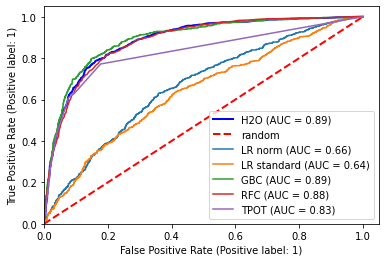

In [76]:
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# H2O best model
out = aml_binary.leader.model_performance(h2o_binary_test)
h2o_fpr = out.fprs
h2o_tpr = out.tprs
h2o_auc = float(out.auc())
print("h2o auc: ", h2o_auc)

# TPOT best pipeline 
tpot_data = dataset
training_features, testing_features, training_target, testing_target = x_train_binary, x_test_binary, y_train_binary, y_test_binary
# Average CV score on the training set was: 0.8309685470630853
tpot_binary_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.45, min_samples_leaf=2, min_samples_split=16, n_estimators=100)),
    DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, min_samples_split=5)
)
tpot_binary_pipeline.fit(training_features, training_target)
# TPOT manual ROC-calculations
probs = tpot_binary_pipeline.predict_proba(testing_features)
preds = probs[:,1]
tpot_fpr, tpot_tpr, tpot_threshold = roc_curve(y_test_binary, preds)
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(preds)
print(tpot_fpr)
print(tpot_tpr)
roc_auc = auc(tpot_fpr, tpot_tpr)
print(roc_auc)



# Plot ROC-Curves
fig = plt.figure()
axis = plt.gca()
lw = 2
plt.plot(h2o_fpr, h2o_tpr, color='blue', lw=lw, label='H2O (AUC = %0.2f)' % 0.88557)# h2o_auc) # H2O
#plt.plot(tpot_fpr, tpot_tpr, 'b', label = 'AUC = %0.2f' % roc_auc) # TPOT
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label="random")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")

RocCurveDisplay.from_estimator(lrc_normalized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR norm", ax=axis)
RocCurveDisplay.from_estimator(lrc_standardized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR standard", ax=axis)
RocCurveDisplay.from_estimator(gbc, x_test_binary, y_test_binary, name="GBC", ax=axis)
RocCurveDisplay.from_estimator(rfc, x_test_binary, y_test_binary, name="RFC", ax=axis)
RocCurveDisplay.from_estimator(tpot_binary_pipeline, x_test_binary, y_test_binary, name="TPOT", ax=axis)

plt.savefig("ROC.svg", format="svg")
plt.show()

In [32]:
h2o_binary_train = h2o.H2OFrame(df_train_binary)
h2o_binary_test = h2o.H2OFrame(df_test_binary)
predictions = aml_binary.leader.predict(h2o_binary_test)
numpy_predictions = predictions.as_data_frame().to_numpy()
predictions_class = predictions["predict"].as_data_frame().to_numpy()

# h2o model predicts probabilities for each class in training set. Therefore 4 values are predicted
# for each feature samle
numpy_y_test = h2o_binary_test[target_name].as_data_frame().to_numpy()
eval.regression_report(numpy_y_test, predictions_class)
eval.classification_report(numpy_y_test, predictions_class)
print(h2o_model.confusion_matrix(data=h2o_test))
rfc_disp = RocCurveDisplay.from_estimator(aml_binary.leader, h2o_binary_test, y_test_binary)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Mean absolute error: 0.14530685920577618
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2588
           1       0.69      0.62      0.65       736

    accuracy                           0.85      3324
   macro avg       0.79      0.77      0.78      3324
weighted avg       0.85      0.85      0.85      3324


x-axis: actual values, y-axis: predicted values
[[2383  205]
 [ 278  458]]

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,2464.0,124.0,0.0,0.0,0.047913,124 / 2.588
1,380.0,310.0,39.0,7.0,0.578804,426 / 736
2,0.0,0.0,0.0,0.0,NaN,0 / 0
3,0.0,0.0,0.0,0.0,NaN,0 / 0
4,2844.0,434.0,39.0,7.0,0.165463,550 / 3.324


# Comparing ROCs

h2o auc:  0.8855734661649083
0.8055085973724884


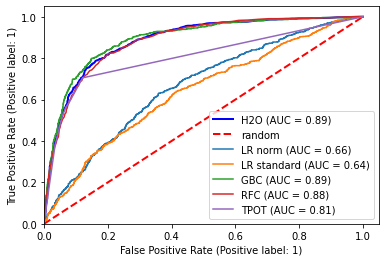

In [92]:
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator
#import builtins
#import matplotlib.pyplot as plt
#from IPython.lib import deepreload
#deepreload.reload(plt)

from sklearn.metrics import roc_curve, auc, roc_auc_score

# H2O best model
out = aml_binary.leader.model_performance(h2o_binary_test)
h2o_fpr = out.fprs
h2o_tpr = out.tprs
h2o_auc = float(out.auc())
print("h2o auc: ", h2o_auc)

# TPOT best pipeline 
tpot_data = dataset
training_features, testing_features, training_target, testing_target = x_train_binary, x_test_binary, y_train_binary, y_test_binary
# Average CV score on the training set was: 0.8309685470630853
tpot_binary_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.45, min_samples_leaf=2, min_samples_split=16, n_estimators=100)),
    DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, min_samples_split=5)
)
tpot_binary_pipeline.fit(training_features, training_target)
# TPOT manual ROC-calculations
probs = tpot_binary_pipeline.predict_proba(testing_features)
preds = probs[:,1]
tpot_fpr, tpot_tpr, tpot_threshold = roc_curve(y_test_binary, preds)
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
roc_auc = auc(tpot_fpr, tpot_tpr)
print(roc_auc)
# You can print tpot_fpr and tpot_tpr to find all values



# Plot ROC-Curves
fig = plt.figure()
axis = plt.gca()
lw = 2
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label="random")
plt.plot(h2o_fpr, h2o_tpr, color='blue', lw=lw, label='H2O (AUC = %0.2f)' % 0.88557)# h2o_auc) # H2O
#plt.plot(tpot_fpr, tpot_tpr, 'b', label = 'AUC = %0.2f' % roc_auc) # TPOT
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")

RocCurveDisplay.from_estimator(lrc_normalized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR norm", ax=axis)
RocCurveDisplay.from_estimator(lrc_standardized_model, x_test_binary_normalized, y_test_binary_normalized, name="LR standard", ax=axis)
RocCurveDisplay.from_estimator(gbc, x_test_binary, y_test_binary, name="GBC", ax=axis)
RocCurveDisplay.from_estimator(rfc, x_test_binary, y_test_binary, name="RFC", ax=axis)
RocCurveDisplay.from_estimator(tpot_binary_pipeline, x_test_binary, y_test_binary, name="TPOT", ax=axis)

#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")

plt.savefig("ROC.svg", format="svg")
plt.show()